# XOR Task

This notebook contains the main results for the XOR logic function task, presented as Figure 5 in the paper.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../../neuroptica")
sys.path.append("..")
from utils import *

import pickle
import time
import neuroptica as neu
import scipy
from scipy import interpolate

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from mpl_toolkits.axes_grid1 import make_axes_locatable
from utils_xor import *

# %matplotlib inline
%config InlineBackend.figure_format = 'svg'

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9

## Define figure function

In [25]:
def plot_xor(model, losses, X, Y, L):
    fig = plt.figure(constrained_layout=True, figsize=(3.5, 5.75))
    gs = mpl.gridspec.GridSpec(4, 1, figure=fig, height_ratios=[1, 1, 1, 2])
    
    ax_schem = fig.add_subplot(gs[0])
    ax_schem.axis('off')
    ax_io    = fig.add_subplot(gs[1])
    ax_loss  = fig.add_subplot(gs[2])
    ax_extra = fig.add_subplot(gs[3])
  
    ax_loss.loglog(losses)
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("MSE")
    ax_loss.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=4))

    L_actual = len(model.layers)

    ticklabels = []
    
    for i, x in enumerate(X.T):
        signal_trace = []
        
        colori = plt.cm.tab20(i/X.shape[1])
        xlabel = np.array2string(np.round(np.abs(x)+0.1), formatter={'float_kind': lambda x: "%.0f\n" % x}, separator="")
        ticklabels.append(xlabel[1:-2])
        
        l0, = ax_io.plot(i, np.abs(Y[0,i]), "x", mec="k", mew=1.25, ms=7)
        l1, = ax_io.plot(i, np.abs(model.forward_pass(x))[0], "o", c="#d62728", mew=1, ms=4)
            
        signal_trace.append( np.linalg.norm(model.layers[0].input_prev) )
        for l, layer in enumerate(model.layers):
            if hasattr(layer, "nonlinearity"):
                if type(layer.nonlinearity) is neu.nonlinearities.ElectroOpticActivation:
                    signal_trace.append( np.linalg.norm(layer.output_prev) )
            
        signal_trace.append(np.linalg.norm(model.forward_pass(x)))

    ax_io.set_xticks(np.arange(0,2**N))
    ax_io.set_xticklabels(ticklabels)
    ax_io.legend(handles=[l0,l1], labels=["Desired output","Learned output"], fontsize="smaller", loc=5)
    ax_io.set_xlabel("Input $x$")
    ax_io.set_ylabel(r"Output $\vert y \vert$")


    apply_sublabels([ax_schem, ax_io, ax_loss, ax_extra], x=-45, y=3, prefix="(", postfix=")", weight="normal")
    
    fig.align_labels()
    
    return fig, ax_extra

## Training

In [15]:
g     = 1.75 * np.pi
phi_b = np.pi

N_pad = 0
L = 2 # Number of layers
N = 4 # Number of inputs
y_scale = 0.20

model = build_network(g=g, g_taper=1, phi_b=phi_b, alpha=0.1, L=L, N=N+N_pad)
X, Y = generate_data_XOR(N, y_scale=y_scale, normalize=True)
X_padded = np.pad(X, ((0,N_pad),(0,0)), mode='constant', constant_values=1)

optimizer = neu.InSituAdam(model, neu.MeanSquaredError, step_size=0.01)
losses = optimizer.fit(X_padded, Y, epochs=5000, batch_size=N**2)

Created 2 layer network


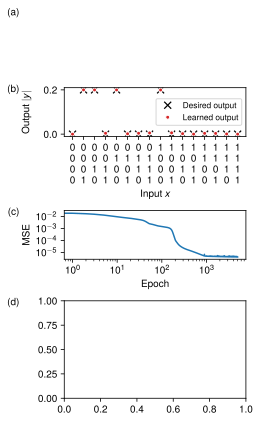

In [16]:
fig, _ = plot_xor(model, losses, X_padded, Y, L)

### Visual check of the data

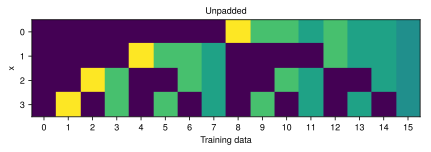

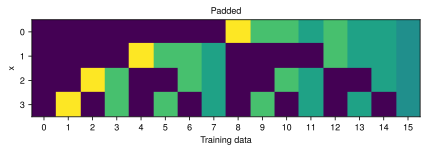

In [6]:
plt.figure()
plt.imshow(np.abs(X))
plt.title("Unpadded")
plt.ylabel("x")
plt.xlabel("Training data")
plt.xticks(np.arange(0,2**N));

plt.figure()
plt.imshow(np.abs(X_padded))
plt.title("Padded")
plt.ylabel("x")
plt.xlabel("Training data")
plt.xticks(np.arange(0,2**N));

## Sweep the gain

In [4]:
L = 2 # Number of layers
N = 4 # Number of inputs
y_scale = 0.20

N_epochs = 5000
N_trials = 20

g_vec     = np.arange(0.25, 2.25, 0.25) * np.pi
phi_b_vec = np.array([-1.0*np.pi, 0.85*np.pi, 0.0*np.pi, 0.5*np.pi])

loss_log = np.zeros((N_trials, g_vec.size, phi_b_vec.size, N_epochs))

In [ ]:
for i, g in enumerate(g_vec):
    for j, phi_b in enumerate(phi_b_vec):
        for k in range(0, N_trials):
            print(k)
            model = build_network(g=g, g_taper=1.0, phi_b=phi_b, alpha=0.1, L=L, N=N)
            X, Y = generate_data_XOR(N, y_scale=y_scale, normalize=True)
            optimizer = neu.InSituAdam(model, neu.MeanSquaredError, step_size=0.01)
            loss_log[k, i, j, :] = optimizer.fit(X, Y, epochs=N_epochs, batch_size=N**2)

pickle.dump( { "loss_log": loss_log, "g_vec": g_vec, "phi_b_vec": phi_b_vec }, open( "loss_log.pkl", "wb" ) )

In [ ]:
data = pickle.load( open( "loss_log.pkl", "rb" ) )
data

In [6]:
loss_min  = np.min(loss_log[:,:,:,-1], axis=0)
loss_max  = np.max(loss_log[:,:,:,-1], axis=0)
loss_mean = np.mean(loss_log[:,:,:,-1], axis=0)
loss_std  = np.std(loss_log[:,:,:,-1],  axis=0)

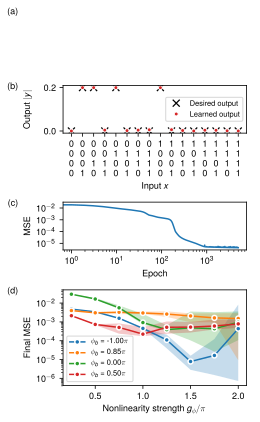

In [30]:
fig, ax = plot_xor(model, losses, X, Y, L);
for j, phi_b in enumerate(phi_b_vec):
    ax.plot(g_vec/np.pi, loss_mean[:,j], "o-", label="$\phi_b$ = %.2f$\pi$" % (phi_b_vec[j]/np.pi), ms=5)
    ax.fill_between(g_vec/np.pi, loss_min[:,j], loss_max[:,j], alpha=0.25)

mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = 9

ax.legend(fontsize="smaller")
ax.set_yscale("log")
ax.set_ylabel("Final MSE")
ax.set_xlabel("Nonlinearity strength $g_\phi/\pi$")
ax.yaxis.set_major_locator(mpl.ticker.LogLocator(numticks=5))